In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy import linalg as la
import math as m

from src.optical_processing import optical_data_preprocessing, crop_videos_to_heart, downsample_videos, \
    get_vertices_without_nans, get_signals, get_connectivity, mean_std_norm

In [2]:
all_results = {}
for RG in [0, 10, 30, 50, 80]:
    optical_path = f'data/RG_analysis_data/09_04_18/RG{RG}_10s.pkl'

    with open(optical_path, 'rb') as f:
        data = pickle.load(f)
        videos = optical_data_preprocessing([data])
        videos = downsample_videos(videos, 1, 4)
        videos = crop_videos_to_heart(videos)
        videos = [mean_std_norm(video, axis=0) for video in videos]


    # get vertices, signals and connectivity structures
    all_vertices = get_vertices_without_nans(videos)  # list length S, elements (W'*D', 2), where W'*D' = N' = num nodes on surface
    conn = get_connectivity(all_vertices)[0]
    signal = get_signals(all_vertices, videos)[0]

    import torch

    from src.models.adaptive.AdaCGP_optical import AdaCGP
    from src.models.adaptive.TISO import TISO
    from src.models.adaptive.TIRSO import TIRSO

    def get_model(name):
        models = {
            'AdaCGP': AdaCGP,
            'TISO': TISO,
            'TIRSO': TIRSO
        }
        if name not in models:
            raise ValueError(f"Model {name} not implemented")
        return models[name]

    def get_ar_data(signal, P, device):
        X = []
        y = []
        for t in range(P, len(signal)):
            xPt = np.stack([signal[t - p] for p in range(1, P+1)], axis=0)
            yt = signal[t]
            X.append(xPt)
            y.append(yt)
            
        X = np.stack(X, axis=0)
        y = np.stack(y, axis=0)[:, :, None]
        return torch.tensor(X, dtype=torch.float32, device=device), torch.tensor(y, dtype=torch.float32, device=device)

    hyperparams = {"P": 3,
                "gamma": 1,
                "w_stepsize": 1e-5,
                "h_stepsize": 1e-5,
                "psi_stepsize": 1e-5,
                "epsilon": 1e-3,
                "lambda": 0.5,
                "nu": 0.01,
                "ma_alpha": 0.005,
                "use_path_1": False,
                "instant_h": True,
                "patience": 100,
                "burn_in_debiasing": 500,
                "min_delta_percent": 0.01,
                "use_armijo": True,
                "warm_up_steps": 0,
                "alternate": False,
                "alternate_mod": 2,
                "monitor_debiasing": 'pred_error_recursive_moving_average_h',
                "mus": [0.1, 0.1, 0.1],
                "store_all_matrices": True,
                "project_to_weight_matrix": True
    }
    device = 'cpu'
    X, y = get_ar_data(signal, hyperparams['P'], device)
    model = get_model('AdaCGP')(signal.shape[1], hyperparams, device)

    # Run optimization
    model_inputs = {
        'X': X,
        'y': y,
        'weight_matrix': torch.tensor(conn, dtype=torch.float32, device=device)
    }

    fname = optical_path.split('/')[-1].split('.')[0]
    fpath = '/'.join(optical_path.split('/')[:-1])
    fsave_name = f"{fpath}/{fname}_results_lambda_{hyperparams['lambda']}_alternating_debias{hyperparams['alternate']}.pkl"

    try:
        with open(fsave_name, 'rb') as f:
            results = pickle.load(f)
    except FileNotFoundError:
        results = model.run(**model_inputs)
        with open(fsave_name, 'wb') as f:
            pickle.dump(results, f)

    results['signal'] = signal
    results['vertices'] = all_vertices[0]
    all_results[RG] = results

/home/alex/Documents/Projects/GraphAR/graphAR/adaptive_graph_ar/src/optical_processing.py:96: RuntimeWarning: invalid value encountered in divide
  s = s / (np.std(s, axis=axis))
/home/alex/Documents/Projects/GraphAR/graphAR/adaptive_graph_ar/src/optical_processing.py:96: RuntimeWarning: invalid value encountered in divide
  s = s / (np.std(s, axis=axis))


In [3]:
import networkx as nx

def draw_graph(t, w, signals, vertices, ax, color_using_embeddings=False):

    adjacency_matrix = w[t]
    np.fill_diagonal(adjacency_matrix, 0)  # No self-loops
    N = adjacency_matrix.shape[0]

    # compute net edge weights, if pos keep diff, if neg zero
    # net_edge_weights = adjacency_matrix - adjacency_matrix.T
    # adjacency_matrix = np.where(net_edge_weights > 0, net_edge_weights, 0)

    # thresh = np.percentile(adjacency_matrix.flatten(), 85)
    # adjacency_matrix[adjacency_matrix < thresh] = 0

    adjacency_matrix = np.where(adjacency_matrix > np.sort(adjacency_matrix, axis=-1)[:, -2][:, None], adjacency_matrix, 0)
    # adjacency_matrix = np.maximum(adjacency_matrix, adjacency_matrix.T) - np.minimum(adjacency_matrix, adjacency_matrix.T)
    net_edge_weights = adjacency_matrix - adjacency_matrix.T
    adjacency_matrix = np.where(net_edge_weights > 0, net_edge_weights, 0)

    node_signals = signals[t]

    # Create a networkx graph from the adjacency matrix
    G = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)

    # Set node positions
    pos = {i: (vertices[i, 0], vertices[i, 1]) for i in range(N)}

    if color_using_embeddings:
        # calculate the laplacian eigenmap and colorby first 3 eigenvectors to RGB values
        from sklearn.manifold import SpectralEmbedding
        embedding = SpectralEmbedding(n_components=3).fit_transform(adjacency_matrix)

        # Normalize the embedding values to the range [0, 1]
        embedding_norm = (embedding - embedding.min(axis=0)) / (embedding.max(axis=0) - embedding.min(axis=0))

        # Create the RGBA color matrix
        color_matrix = np.zeros((embedding.shape[0], 4))
        color_matrix[:, 0] = embedding_norm[:, 0]  # Red
        color_matrix[:, 1] = embedding_norm[:, 1]  # Green
        color_matrix[:, 2] = embedding_norm[:, 2]  # Blue
        color_matrix[:, 3] = 1.0  # Alpha channel set to 1.0 (fully opaque)
        colors = color_matrix
    else:
        # Normalize node signals to map to the 'viridis' colormap
        min_signal = min(node_signals)
        max_signal = max(node_signals)
        colors = [(signal - min_signal) / (max_signal - min_signal) for signal in node_signals]

    # set weights
    try:
        weights = [G[u][v]['weight'] for u,v in G.edges()]
        weights = np.array(weights)
        weights /= weights.max()
        weights *= 4
    except:
        weights = None
    

    # Drawing the graph
    # plot the nodes only
    nx.draw(G, pos, node_color=colors, cmap=None if color_using_embeddings else plt.cm.jet, with_labels=False, arrows=True, arrowsize=5, edge_color='gray', node_size=30, width=weights/2, ax=ax, node_shape="s")

In [4]:
len(all_results[0]['pred_error'])

3951

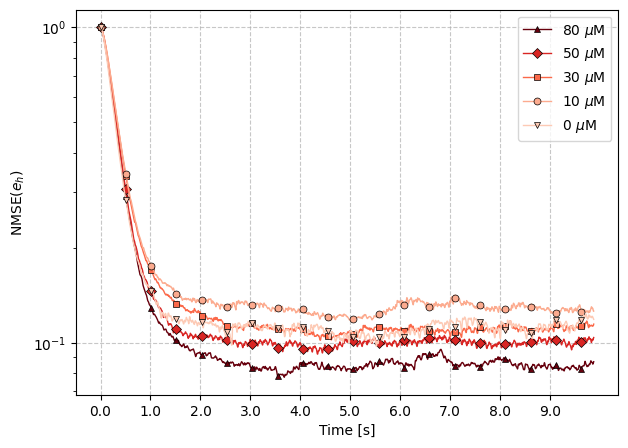

In [7]:
T_max = 3900

cmap = plt.get_cmap('Reds')

fig = plt.figure(figsize=(7, 5))
for i, RG in enumerate([80, 50, 30, 10, 0]):
    # if RG == 0:
    #     continue
    results = all_results[RG]
    lcolor = cmap((RG+20) / 100)
    y_error = np.array(results['pred_error_from_h'])
    y_error_ma = [1]
    for i in range(1, len(y_error)):
        ma_t = 0.01 * y_error[i] + (1 - 0.01) * y_error_ma[-1]
        y_error_ma.append(ma_t)
    y_error_ma = np.array(y_error_ma)

    if RG == 0:
        lmarker = 'v'
        lstyle = '-'
    elif RG == 10:
        lmarker = 'o'
        lstyle = '-'
    elif RG == 30:
        lmarker = 's'
        lstyle = '-'
    elif RG == 50:
        lmarker = 'D'
        lstyle = '-'
    elif RG == 80:
        lmarker = '^'
        lstyle = '-'
    
    plt.plot(y_error_ma[:T_max], label=str(RG) + ' $\mu$M', color=lcolor, marker=lmarker, markevery=200, markersize=5, markeredgecolor='black', markeredgewidth=0.5, linewidth=1, alpha=1, linestyle=lstyle)
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('NMSE(${e_h}$)')
plt.yscale('log')
# convert x scale to seconds where each 1 second == 395 iterations
plt.xticks(np.arange(0, T_max, 395), np.arange(0, T_max/395))
plt.grid(True, linestyle='--', alpha=0.7)
# save as svg file in figures
plt.savefig('figures/09_04_18_optical_convergence_vs_RGdose.svg')
plt.show()

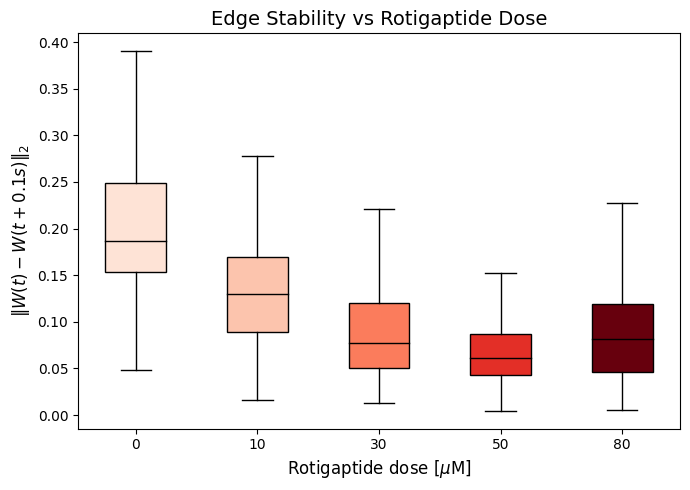

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_edge_stability(Ws_steady_RG, window=40):
    return np.array([np.linalg.norm(Ws_steady_RG[i] - Ws_steady_RG[i+window])
                     for i in range(len(Ws_steady_RG) - window)])

def plot_edge_stability(all_results):
    fig, ax = plt.subplots(figsize=(7, 5))
    cmap = plt.get_cmap('Reds')

    rotigaptide_doses = [0, 10, 30, 50, 80]
    box_positions = []
    box_data = []

    for i, RG in enumerate(rotigaptide_doses):
        results = all_results[RG]
        first_alg_converged_status = results['first_alg_converged_status']
        matrices = np.stack(results['matrices'])
        
        Ws_steady_RG = matrices[1:][first_alg_converged_status]
        
        edge_stability = calculate_edge_stability(Ws_steady_RG)
        
        box_positions.append(i*10)
        box_data.append(edge_stability)

    box_props = dict(linewidth=1, edgecolor='black')
    whisker_props = dict(linewidth=1)
    median_props = dict(linewidth=1, color='black')

    bp = ax.boxplot(box_data, positions=box_positions, widths=5, patch_artist=True,
                    boxprops=box_props, whiskerprops=whisker_props, medianprops=median_props,
                    showfliers=False)

    for patch, RG in zip(bp['boxes'], rotigaptide_doses):
        patch.set_facecolor(cmap((RG+10) / 90))

    ax.set_xlabel('Rotigaptide dose [$\mu$M]', fontsize=12)
    ax.set_ylabel('$\Vert W(t) - W(t+0.1s) \Vert_2$', fontsize=12)
    ax.set_title('Edge Stability vs Rotigaptide Dose', fontsize=14)

    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)

    # change x ticks to dose values
    ax.set_xticklabels(rotigaptide_doses, fontsize=10)

    plt.tight_layout()
    plt.savefig('figures/09_04_18_optical_edge_stability_vs_RGdose.svg', bbox_inches='tight')
    plt.show()

# Assuming all_results is defined
plot_edge_stability(all_results)

/tmp/ipykernel_700388/4155480939.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0', '0', '0.05', '0.1', '0.15', '0.2', '0.25'], fontsize=10)


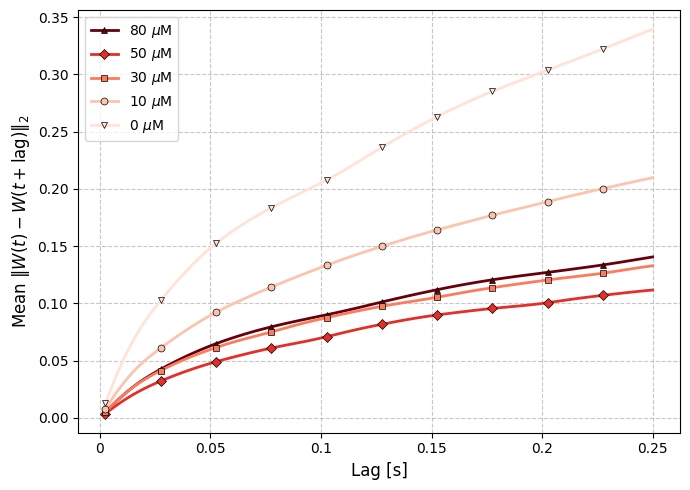

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_edge_stability_for_lags(Ws_steady_RG, max_lag=100):
    lags = range(1, min(max_lag + 1, len(Ws_steady_RG)))
    stability = []
    for lag in lags:
        stability.append(np.mean([np.linalg.norm(Ws_steady_RG[j] - Ws_steady_RG[j+lag])
                                  for j in range(len(Ws_steady_RG) - lag)]))
    return lags, np.array(stability)

def plot_l2_norm_vs_lag(all_results, in_node=100, max_lag=100):
    fig, ax = plt.subplots(figsize=(7, 5))
    cmap = plt.get_cmap('Reds')

    rotigaptide_doses = [80, 50, 30, 10, 0]
    
    for i, RG in enumerate(rotigaptide_doses):
        results = all_results[RG]
        first_alg_converged_status = results['first_alg_converged_status']
        matrices = np.stack(results['matrices'])
        
        Ws_steady_RG = matrices[1:][first_alg_converged_status]
        
        lags, avg_stability = calculate_edge_stability_for_lags(Ws_steady_RG, max_lag)
        
        color = cmap((RG+10) / 90)
        if RG == 0:
            lmarker = 'v'
            lstyle = '-'
        elif RG == 10:
            lmarker = 'o'
            lstyle = '-'
        elif RG == 30:
            lmarker = 's'
            lstyle = '-'
        elif RG == 50:
            lmarker = 'D'
            lstyle = '-'
        elif RG == 80:
            lmarker = '^'
            lstyle = '-'
        ax.plot(lags, avg_stability, color=color, label=f'{RG} $\mu$M', marker=lmarker, markevery=10, markersize=5, markeredgecolor='black', markeredgewidth=0.5, linewidth=2, alpha=1, linestyle=lstyle)

    ax.set_xlabel('Lag [s]', fontsize=12)
    ax.set_ylabel('Mean $\Vert W(t) - W(t+\mathrm{lag}) \Vert_2$', fontsize=12)
    # ax.set_title('Edge Stability vs Lag for Different Rotigaptide Doses', fontsize=14)

    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

    # change the xlabels to 
    ax.set_xticklabels(['0', '0', '0.05', '0.1', '0.15', '0.2', '0.25'], fontsize=10)

    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    plt.savefig('figures/09_04_18_optical_avg_edge_stability_vs_lag.svg', bbox_inches='tight')
    plt.tight_layout()
    # plt.legend()
    plt.show()

# Assuming all_results is defined
plot_l2_norm_vs_lag(all_results, max_lag=100)

In [10]:
Ws = np.stack(all_results[0]['matrices'][1:])[all_results[0]['first_alg_converged_status']]
verts = all_results[0]['vertices']

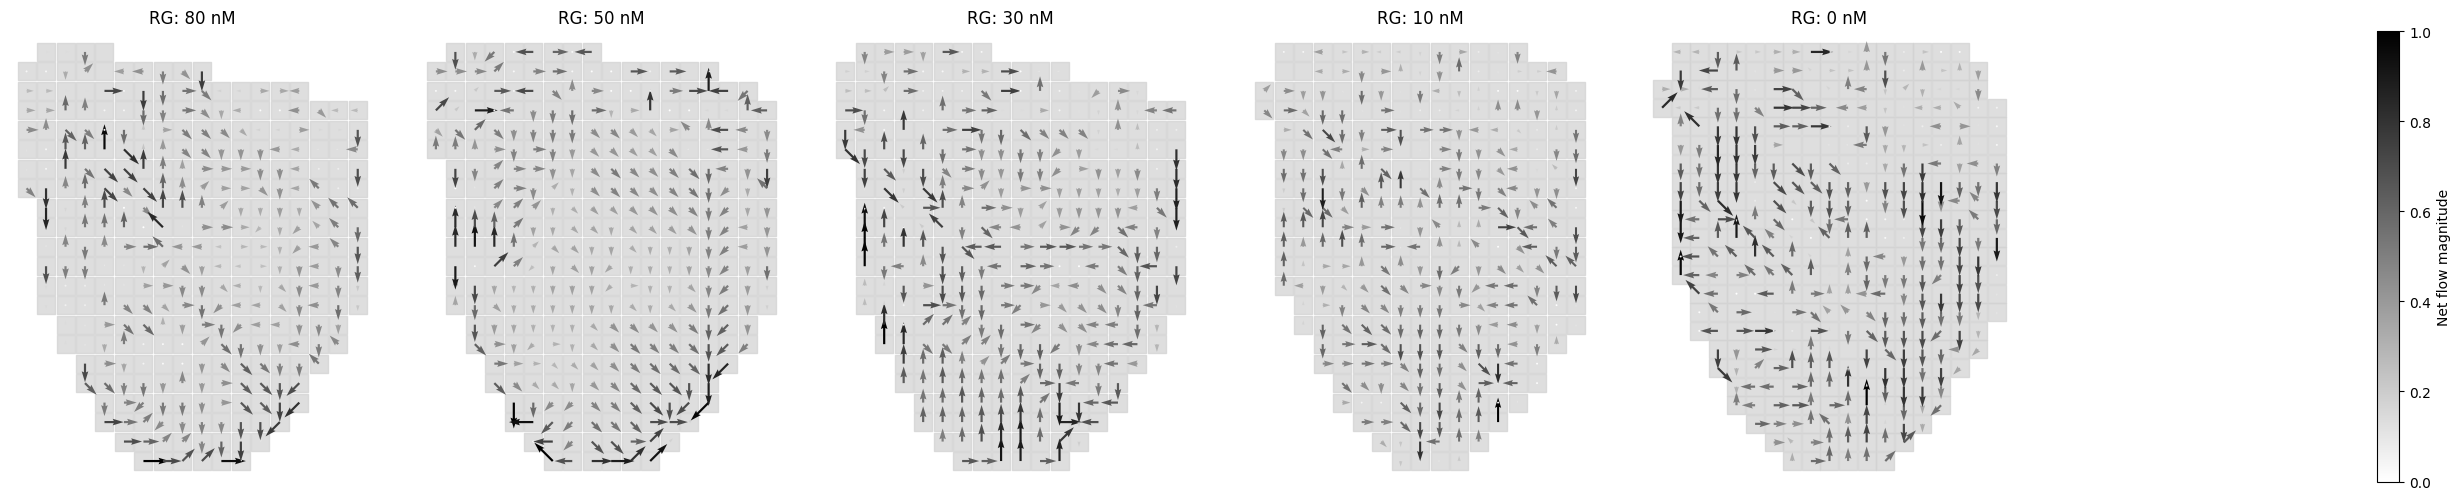

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def compute_net_flow(W, verts):
    n = W.shape[0]
    net_flow = np.zeros((n, 2))
    
    for i in range(n):
        for j in range(n):
            if W[i, j] != 0:
                if i != j:
                    direction = verts[j] - verts[i]
                    direction /= np.linalg.norm(direction)
                    net_flow[i] += direction * (W[i, j] - W[j, i])
        
    return net_flow

def plot_net_edge_flow(all_results, t=1000, figsize=(25, 5), save_dir=None):
    fig, axes = plt.subplots(1, 6, figsize=figsize)
    axes = axes.flatten()

    rotigaptide_doses = [80, 50, 30, 10, 0]
    cmap = plt.cm.binary

    for idx, RG in enumerate(rotigaptide_doses):
        ax = axes[idx]
        results = all_results[RG]
        verts = results['vertices'].astype(float)
        signal = results['signal']
        W = results['matrices'][t]

        # Remove self-loops and keep only the strongest edge for each node
        np.fill_diagonal(W, 0)
        W = np.where(W == np.sort(W, axis=-1)[:, -1][:, None], W, 0)

        # Compute net flow
        net_flow = compute_net_flow(W, verts)
        
        # Normalize net flow for better visualization
        net_flow_magnitude = np.linalg.norm(net_flow, axis=1)
        max_magnitude = np.max(net_flow_magnitude)
        net_flow_normalized = net_flow / max_magnitude if max_magnitude > 0 else net_flow

        # Create quiver plot
        ax.scatter(verts[:, 0], verts[:, 1], c='lightgray', s=160, marker='s', alpha=.75)
        ax.quiver(verts[:, 0], verts[:, 1], net_flow_normalized[:, 0], net_flow_normalized[:, 1],
                  net_flow_magnitude, cmap=cmap, scale=14, width=0.006)

        # Plot settings
        ax.set_aspect('equal')
        ax.set_title(f'RG: {RG} nM')
        ax.axis('off')

    # Add colorbar
    fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=axes[-1], label='Net flow magnitude')

    # Remove the last (empty) subplot
    fig.delaxes(axes[-1])
    plt.tight_layout()
    if save_dir is not None:
        plt.savefig(save_dir, bbox_inches='tight')
    plt.show()
    plt.close()


save_dir = 'figures/RG_mp4'
os.makedirs(save_dir, exist_ok=True)

min_t = min([len(all_results[RG]['first_alg_converged_status']) for RG in [0, 10, 30, 50, 80]])

t = 1000
plot_net_edge_flow(all_results, t=t, save_dir=f'{save_dir}/{t}.png')

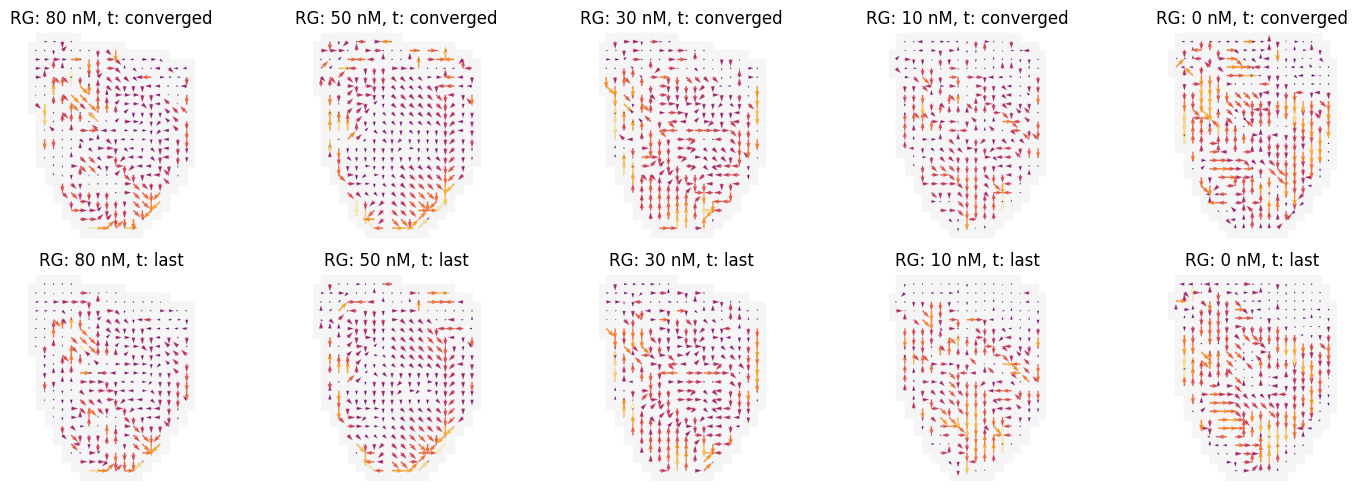

In [12]:
def plot_net_edge_flow_two_timepoints(all_results, figsize=(15, 5), save_dir=None):
    fig, axes = plt.subplots(2, 5, figsize=figsize)

    rotigaptide_doses = [80, 50, 30, 10, 0]
    cmap = plt.cm.inferno

    for idx, RG in enumerate(rotigaptide_doses):
        results = all_results[RG]
        verts = results['vertices'].astype(float)
        first_alg_converged_status = results['first_alg_converged_status']
        matrices = results['matrices']

        # Find the index of the first True value in first_alg_converged_status
        t_converged = np.argmax(first_alg_converged_status)
        
        # Get the last matrix
        t_last = len(matrices) - 1

        for row, t in enumerate([t_converged, t_last]):
            ax = axes[row, idx]
            W = matrices[t]

            # Remove self-loops and keep only the strongest edge for each node
            np.fill_diagonal(W, 0)
            W = np.where(W == np.sort(W, axis=-1)[:, -1][:, None], W, 0)

            # Compute net flow
            net_flow = compute_net_flow(W, verts)
            
            # Normalize net flow for better visualization
            net_flow_magnitude = np.linalg.norm(net_flow, axis=1)
            max_magnitude = np.max(net_flow_magnitude)
            net_flow_normalized = net_flow / max_magnitude if max_magnitude > 0 else net_flow

            # Create quiver plot
            ax.scatter(verts[:, 0], verts[:, 1], c='whitesmoke', s=160, marker='s', alpha=1)
            ax.quiver(verts[:, 0], verts[:, 1], net_flow_normalized[:, 0], net_flow_normalized[:, 1],
                      net_flow_magnitude, cmap=cmap, scale=11, width=0.008, edgecolors='orchid', linewidths=0.1)

            # Plot settings
            ax.set_aspect('equal')
            ax.set_title(f'RG: {RG} nM, t: {"converged" if row == 0 else "last"}')
            ax.axis('off')

    # Add colorbar
    # fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=axes[:, -1], label='Net flow magnitude')

    plt.tight_layout()
    if save_dir is not None:
        plt.savefig(save_dir, bbox_inches='tight')
    plt.show()
    plt.close()

# Usage:
save_dir = 'figures/RG_two_timepoints'
os.makedirs(save_dir, exist_ok=True)

plot_net_edge_flow_two_timepoints(all_results, save_dir=f'{save_dir}/net_flow_comparison.svg')

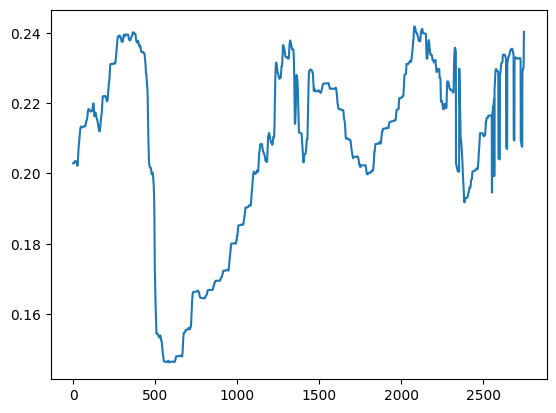

In [162]:
plt.plot(flow_magnitudes[:, 20])

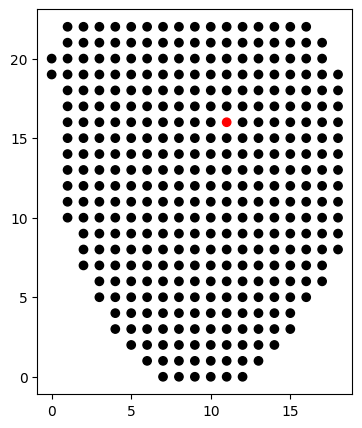

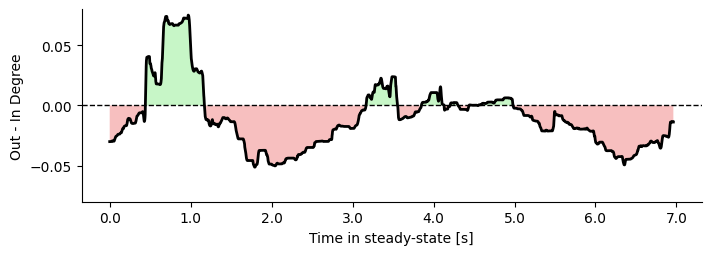

In [264]:
from tqdm import tqdm

RG = 0
n = 213 if RG == 50 else 220
results = all_results[RG]
first_alg_converged_status = results['first_alg_converged_status']
matrices = np.stack(results['matrices'])
Ws_steady = matrices[1:][first_alg_converged_status]
vs = all_results[RG]['vertices']
cs = ['k']*len(vs)
cs[n] = 'r'

# show point 100
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(vs[:, 0], vs[:, 1], c=cs)
ax.set_aspect('equal')
plt.show()

cmap = plt.get_cmap('Reds')
color = cmap((RG+10) / 90)
if RG == 0:
    lmarker = 'v'
    lstyle = '-'
elif RG == 10:
    lmarker = 'o'
    lstyle = '-'
elif RG == 30:
    lmarker = 's'
    lstyle = '-'
elif RG == 50:
    lmarker = 'D'
    lstyle = '-'
elif RG == 80:
    lmarker = '^'
    lstyle = '-'

fig, ax = plt.subplots(figsize=(8, 2.5))
ax.plot(np.sum(Ws_steady[:, n, :], axis=1) - np.sum(Ws_steady[:, :, n], axis=1), label='out - in', linewidth=2, color='black')

# highlight area between curve and 0
plt.fill_between(np.arange(len(Ws_steady)), np.sum(Ws_steady[:, n, :], axis=1) - np.sum(Ws_steady[:, :, n], axis=1), 0, where=np.sum(Ws_steady[:, n, :], axis=1) - np.sum(Ws_steady[:, :, n], axis=1) > 0, facecolor='lightgreen', alpha=0.5)

# fill between 0 and the curve for negative values
plt.fill_between(np.arange(len(Ws_steady)), np.sum(Ws_steady[:, n, :], axis=1) - np.sum(Ws_steady[:, :, n], axis=1), 0, where=np.sum(Ws_steady[:, n, :], axis=1) - np.sum(Ws_steady[:, :, n], axis=1) < 0, facecolor='lightcoral', alpha=0.5)
plt.xlabel('Time in steady-state [s]')
plt.ylabel('Out - In Degree')

# draw line along y=0
plt.axhline(0, color='black', linewidth=1, linestyle='--')

# convert x scale to seconds where each 1 second == 395 iterations
plt.xticks(np.arange(0, T_max-(2*395), 395), np.arange(0, (T_max-(2*395))/395))
# plt.grid(True, linestyle='--', alpha=0.7)

# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# grey plot backgorund
plt.ylim(-0.08, 0.08)

# save fig
plt.savefig(f'figures/RG{RG}_node{n}_in_out_degree.svg', bbox_inches='tight', format='svg')
plt.show()

In [15]:
# find the ind with the max Ws_steady
i, j = 100, 101
plt.plot(Ws_steady[:, i, j], label='in-edge')
plt.plot(Ws_steady[:, j, i], label='out-edge')
plt.plot(Ws_steady[:, i, j] - Ws_steady[:, j, i], label='in - out')
plt.legend()
plt.ylabel(f'Edge weight between nodes {i} and {j}')
plt.xlabel('Iterations')
plt.axhline(0, color='black', linestyle='--')
plt.show()

# plot the in-degree of node i
i = 100
plt.plot(np.sum(Ws_steady[:, :, i], axis=1), label='in-degree')
plt.plot(np.sum(Ws_steady[:, i, :], axis=1), label='out-degree')
plt.plot(np.sum(Ws_steady[:, :, i], axis=1) - np.sum(Ws_steady[:, i, :], axis=1), label='in - out')
plt.legend()
plt.ylabel(f'Degree of node {i}')
plt.xlabel('Iterations')
# dashed line along the x-axis at 0
plt.axhline(0, color='black', linestyle='--')
plt.show()

NameError: name 'Ws_steady' is not defined

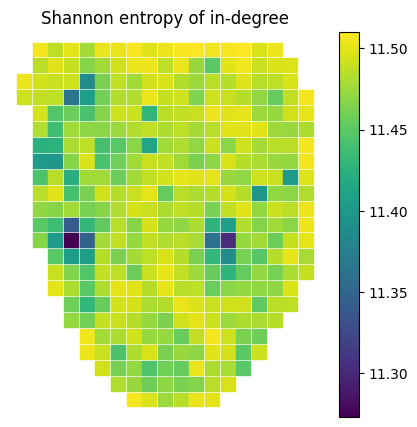

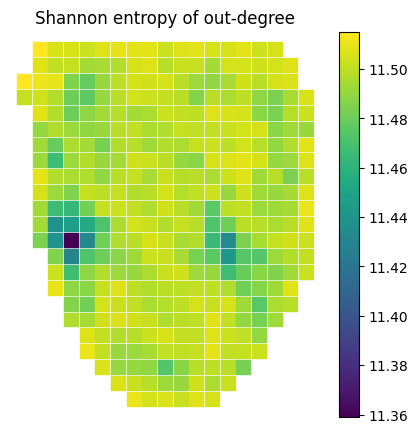

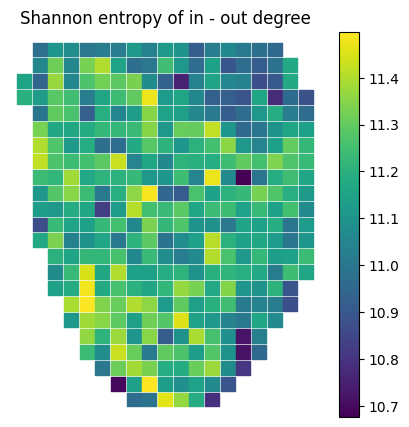

In [53]:
# compute the in - out degree of each node
in_deg = np.sum(Ws_steady, axis=1)
out_deg = np.sum(Ws_steady, axis=2)
deg_diff = in_deg - out_deg

# compute the shannon entropy of each deg_diff
from scipy.stats import entropy

for data in [in_deg, out_deg, deg_diff]:
    entropies = np.array([entropy(np.abs(d), base=2) for d in data.T])

    # plot the entropy of each node on the vertices
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.axis('off')
    plt.scatter(all_vertices[0][:, 0], all_vertices[0][:, 1], c=entropies, cmap='viridis', s=100, marker='s')
    plt.title(f'Shannon entropy of {"in-degree" if data is in_deg else "out-degree" if data is out_deg else "in - out degree"}')
    plt.colorbar()
    plt.show()

In [54]:
processed_Ws = []
for W in Ws_steady:
    np.fill_diagonal(W, 0)
    # W = np.where(W > np.sort(W, axis=-1)[:, -2][:, None], W, 0)
    # net_edge_weights = W - W.T
    # W = np.where(net_edge_weights > 0, net_edge_weights, 0)
    processed_Ws.append(W)
processed_Ws = np.stack(processed_Ws)

In [55]:
# add min value to processed_Ws
processed_Ws += np.abs(processed_Ws.min())
entropies_edges = entropy(processed_Ws, base=2, axis=0)

/tmp/ipykernel_3761897/861783416.py:30: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



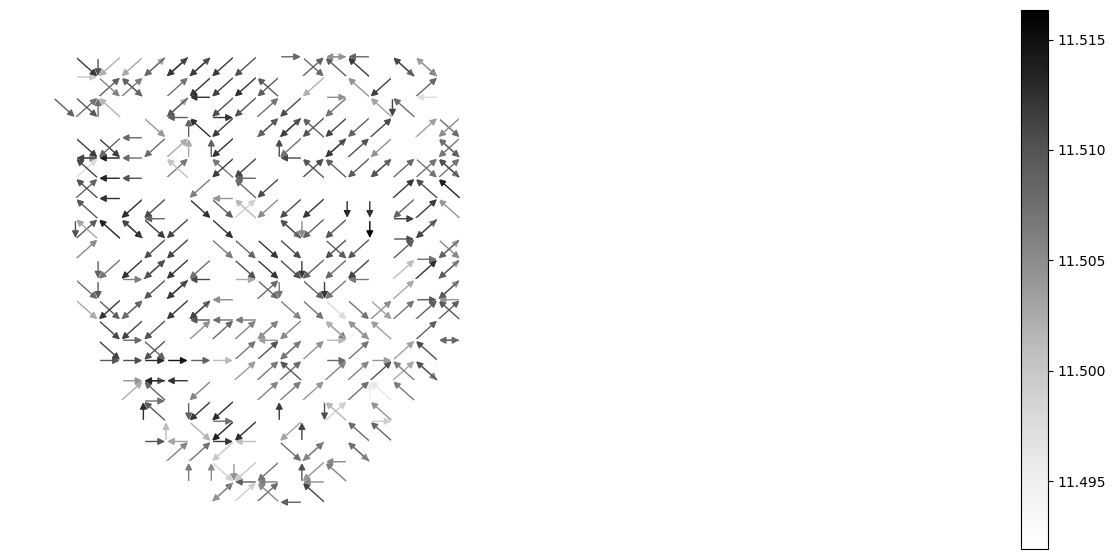

In [56]:
entropy_edges = entropies_edges * conn
np.fill_diagonal(entropy_edges, 0)
entropy_edges = np.where(entropy_edges > np.sort(entropy_edges, axis=-1)[:, -2][:, None], entropy_edges, 0) # get the biggest value at each row
# net_edge_weights = W - W.T
# W = np.where(net_edge_weights > 0, net_edge_weights, 0)


# plot as networkx graph with colored edges
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
for ax in axs:
    ax.axis('off')

# Create a networkx graph from the adjacency matrix
G = nx.from_numpy_array(entropy_edges, create_using=nx.DiGraph)

# Set node positions
pos = {i: (all_vertices[0][i, 0], all_vertices[0][i, 1]) for i in range(entropy_edges.shape[0])}

# store the edge weights
weights = [G[u][v]['weight'] for u,v in G.edges()]
weights = np.array(weights)
# weights /= weights.max()

# draw the edges and color them by their magnitude
cmap = plt.cm.Greys
nx.draw(G, pos, node_color='white', with_labels=False, arrows=True, arrowsize=10, edge_color=weights, edge_cmap=cmap, node_size=1, width=1, ax=axs[0], node_shape="s")

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = weights.min(), vmax=weights.max()))
sm._A = []
plt.colorbar(sm)
plt.show()

# plot using median weights


/tmp/ipykernel_3761897/1753392888.py:25: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



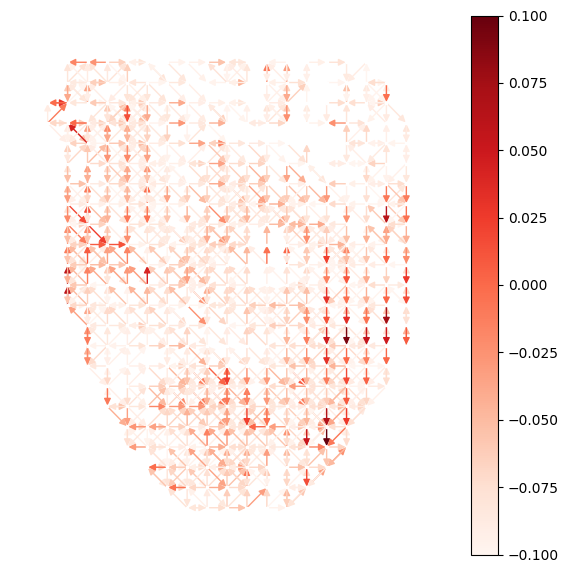

/tmp/ipykernel_3761897/1753392888.py:52: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



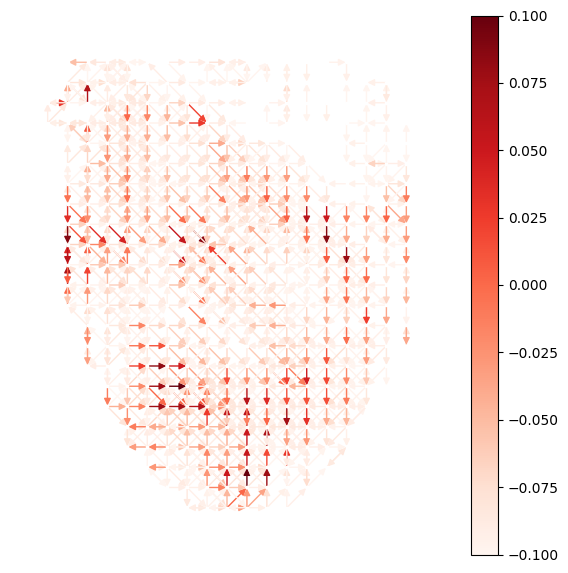

In [57]:
std_edges = Ws_steady.std(axis=0)

# plot as networkx graph with colored edges
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Create a networkx graph from the adjacency matrix
G = nx.from_numpy_array(std_edges, create_using=nx.DiGraph)

# Set node positions
pos = {i: (all_vertices[0][i, 0], all_vertices[0][i, 1]) for i in range(std_edges.shape[0])}

# store the edge weights
weights = [G[u][v]['weight'] for u,v in G.edges()]
weights = np.array(weights)

# filter weights
thresh = np.percentile(weights, 50)
weights = np.where(weights > thresh, weights, np.nan)

# draw the edges and color them by their magnitude
cmap = plt.cm.Reds
nx.draw(G, pos, node_color='white', with_labels=False, arrows=True, arrowsize=10, edge_color=weights, edge_cmap=cmap, node_size=1, width=1, ax=ax, node_shape="s")
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = weights.min(), vmax=weights.max()))
sm._A = []
plt.colorbar(sm)
plt.show()

median_edges = np.median(Ws_steady, axis=0)

# plot as networkx graph with colored edges
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Create a networkx graph from the adjacency matrix
G = nx.from_numpy_array(median_edges, create_using=nx.DiGraph)

# Set node positions
pos = {i: (all_vertices[0][i, 0], all_vertices[0][i, 1]) for i in range(median_edges.shape[0])}

# store the edge weights
weights = [G[u][v]['weight'] for u,v in G.edges()]
weights = np.array(weights)

# filter weights
thresh = np.percentile(weights, 50)
weights = np.where(weights > thresh, weights, np.nan)

# draw the edges and color them by their magnitude
cmap = plt.cm.Reds
nx.draw(G, pos, node_color='white', with_labels=False, arrows=True, arrowsize=10, edge_color=weights, edge_cmap=cmap, node_size=1, width=1, ax=ax, node_shape="s")
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = weights.min(), vmax=weights.max()))
sm._A = []
plt.colorbar(sm)
plt.show()

/tmp/ipykernel_3761897/321800123.py:6: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_3761897/321800123.py:30: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



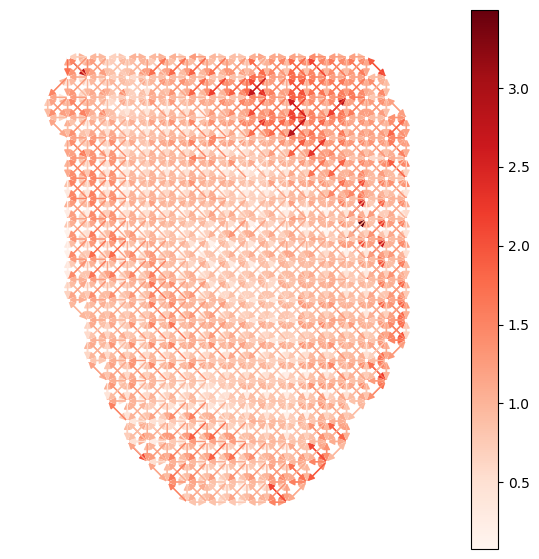

In [58]:
# coefficient of variation
mean_edges = np.mean(Ws_steady, axis=0)
std_edges = np.std(Ws_steady, axis=0)

# compute CV and handle division by zero
cv_edges = np.where(mean_edges > 0, std_edges / mean_edges, 0)

# plot as networkx graph with colored edges
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Create a networkx graph from the adjacency matrix
G = nx.from_numpy_array(cv_edges, create_using=nx.DiGraph)

# Set node positions
pos = {i: (all_vertices[0][i, 0], all_vertices[0][i, 1]) for i in range(cv_edges.shape[0])}

# store the edge weights
weights = [G[u][v]['weight'] for u,v in G.edges()]
weights = np.array(weights)

# filter weights
# thresh = np.percentile(weights, 50)
# weights = np.where(weights > thresh, weights, 0)

# draw the edges and color them by their magnitude
cmap = plt.cm.Reds
nx.draw(G, pos, node_color='white', with_labels=False, arrows=True, arrowsize=10, edge_color=weights, edge_cmap=cmap, node_size=1, width=1, ax=ax, node_shape="s")
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = weights.min(), vmax=weights.max()))
sm._A = []
plt.colorbar(sm)
plt.show()

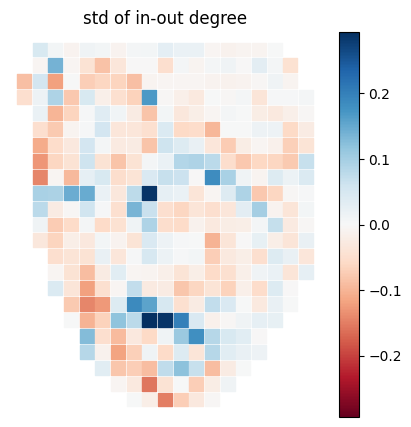

In [62]:
from matplotlib.colors import Normalize

data = np.median(Ws_steady.sum(axis=-2) - Ws_steady.sum(axis=-1), axis=0)

# Determine the symmetric range around 0
vmax = max(abs(data.min()), abs(data.max()))

# Create the Normalize object
norm = Normalize(vmin=-vmax, vmax=vmax)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.axis('off')
scatter = plt.scatter(all_vertices[0][:, 0], all_vertices[0][:, 1], c=data, cmap='RdBu', s=100, marker='s', norm=norm)
plt.title('std of in-out degree')
plt.colorbar(scatter)
plt.show()

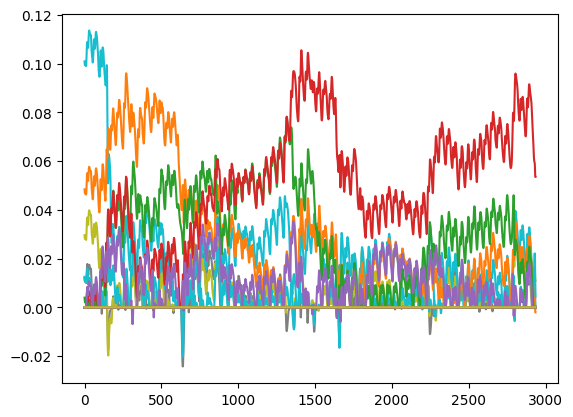

In [67]:
plt.plot(Ws_steady[:, 100, :])

In [68]:
# stability of the processed Ws
# compute the eigenvalues

def get_eig(rho):
    EV = la.eigvals(rho)
    return EV


In [69]:

max_eigs = [get_eig(W)[0] for W in tqdm(Ws_steady)]

100%|██████████| 2934/2934 [02:13<00:00, 22.03it/s]


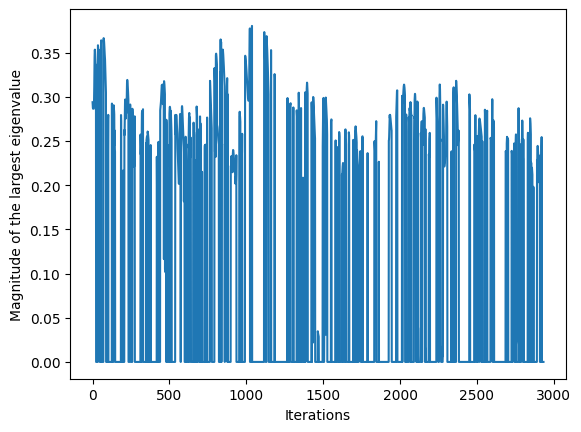

In [70]:
plt.plot(np.abs(np.array(max_eigs)))
plt.xlabel('Iterations')
plt.ylabel('Magnitude of the largest eigenvalue')
plt.show()

In [71]:
# normalise the Ws_steady_vf weights at each time to 0-1
Ws_steady_norm = (Ws_steady - Ws_steady.min(axis=(1,2))[:, None, None]) / (Ws_steady.max(axis=(1,2)) - Ws_steady.min(axis=(1,2)))[:, None, None]


In [72]:
from scipy.stats import entropy
Es = entropy(np.abs(Ws_steady_norm), base=2, axis=0) 

In [76]:
Es[Es == Es[-1, 0]] = np.nan
np.fill_diagonal(Es, np.nan)

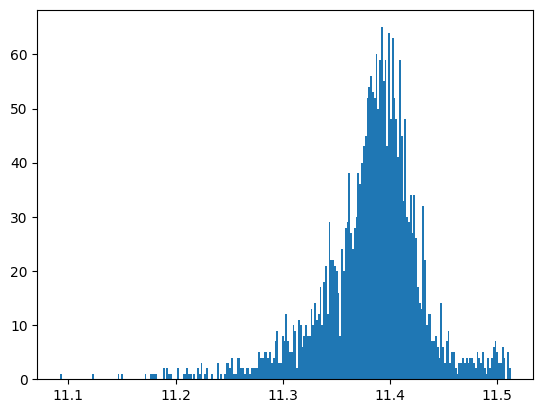

In [77]:
es_flat = Es.flatten()
es_flat = es_flat[~np.isnan(es_flat)]
es_flat_filt = es_flat[(es_flat > np.percentile(es_flat, 0)) & (es_flat < np.percentile(es_flat, 100))]

plt.hist(es_flat_filt, bins=250)
plt.show()

/tmp/ipykernel_3761897/1518527399.py:26: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



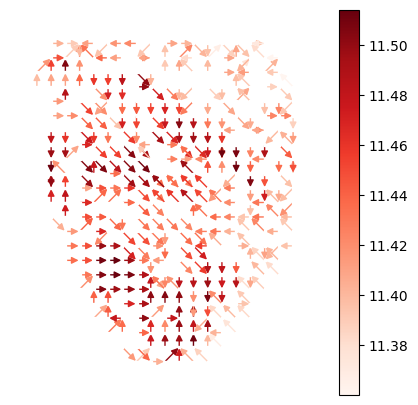

In [99]:
# plot the entropy es_flat_filt on the edges
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.axis('off')

# Create a networkx graph from the adjacency matrix, fill nans in Es
A = np.nan_to_num(Es)
A = np.where(A == np.sort(A, axis=-1)[:, -1][:, None], A, 0) # get the biggest value at each row
G = nx.from_numpy_array(A, create_using=nx.DiGraph)

# Set node positions
pos = {i: (all_vertices[0][i, 0], all_vertices[0][i, 1]) for i in range(Es.shape[0])}

# store the edge weights
weights = [G[u][v]['weight'] for u,v in G.edges()]
weights = np.array(weights)

# filter weights
# thresh = np.percentile(weights, 50)
# weights = np.where(weights > thresh, weights, np.nan)

# draw the edges and color them by their magnitude
cmap = plt.cm.Reds
nx.draw(G, pos, node_color='white', with_labels=False, arrows=True, arrowsize=10, edge_color=weights, edge_cmap=cmap, node_size=1, width=1, ax=ax, node_shape="s")
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = weights.min(), vmax=weights.max()))
sm._A = []
plt.colorbar(sm)
plt.show()

In [154]:
(A!=0) * 

array([[False,  True, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False,  True, False],
       [False, False, False, ...,  True, False,  True],
       [False, False, False, ..., False,  True, False]])

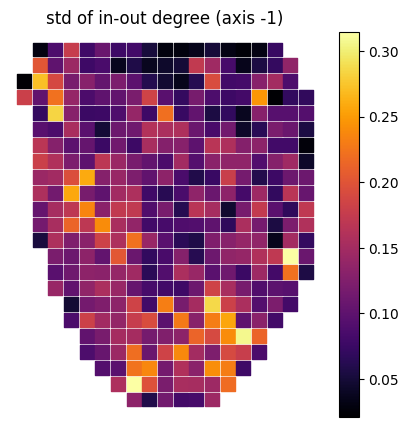

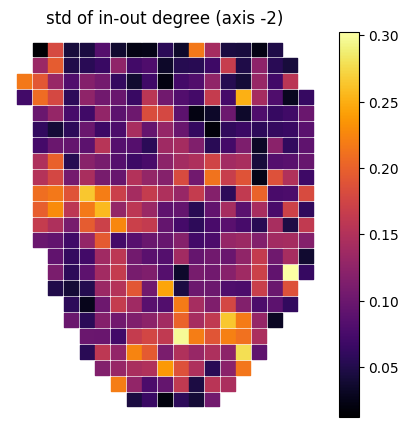

In [158]:
import numpy as np
import matplotlib.pyplot as plt

# Replace zeros with np.nan
A = np.nan_to_num(Es)
A_non_zero = np.where(A == 0, np.nan, A)

# Find the minimum non-zero value along the specified axis
min_non_zero_val_axis_1 = np.nanmin(A_non_zero, axis=-1)
min_non_zero_val_axis_2 = np.nanmin(A_non_zero, axis=-2)

# Calculate data using the minimum non-zero values
data_axis_1 = A.max(axis=-1) - min_non_zero_val_axis_1
data_axis_2 = A.max(axis=-2) - min_non_zero_val_axis_2

# Plotting for axis -1
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.axis('off')
scatter = plt.scatter(all_vertices[0][:, 0], all_vertices[0][:, 1], c=data_axis_1, cmap='inferno', s=100, marker='s')
plt.title('std of in-out degree (axis -1)')
plt.colorbar(scatter)
plt.show()

# Plotting for axis -2
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.axis('off')
scatter = plt.scatter(all_vertices[0][:, 0], all_vertices[0][:, 1], c=data_axis_2, cmap='inferno', s=100, marker='s')
plt.title('std of in-out degree (axis -2)')
plt.colorbar(scatter)
plt.show()